# Необходимые библиотеки

In [1]:
%%capture
!pip install spacy
!python -m spacy download ru_core_news_sm

In [2]:
%%capture
!pip install gensim

In [1]:
import numpy as np
import pandas as pd
import re
import string
import spacy
from functools import reduce
import operator
import matplotlib.pyplot as plt

# Класс, вычисляющий основные количественные характеристики документов

In [2]:
class Calc_docs_characteristics:
    def __init__(
        self,
        docs: pd.DataFrame,
        columns: list[str],
        num_tokens_column: str = "num_tokens_column",
        tokens_column: str = "tokens_column",
        num_unique_tokens_column: str = "num_unique_tokens_column",
        is_prepearing_docs: bool = False
    ):
        '''Инициализация.\n
    docs: pd.DataFrame - документы, по будут вычислять метрики;\n
    columns: list[str] - столбцы документов, по которым будут вычисляться
    метрики;\n
    num_tokens_column: str - названия столбца, который будет хранить число
    слов в документе;\n
    tokens_column: str - название столбца, который будет хранить слова
    документа;\n
    num_unique_tokens_column: str - названия столбца, который будет хранить
    число уникальных слов документа;\n
    is_prepearing_docs: bool - говорит нужно ли подготовливать данные или
    нет (если для вычисления характеристик подаются неподготовленные данные);\n
    stop_words_frequency: int - частота встречаемости слова в массиве
    документов которая говорит является ли слово с такой (или ниже) частотой
    встречаемости стоп-словом или нет.'''
        self.nlp_en = spacy.load("en_core_web_sm")
        self.nlp_ru = spacy.load("ru_core_news_sm")

        self.docs = docs.copy(deep=True)
        self.docs = self.docs.fillna("")
        self.docs = self.docs.astype(str)
        self.columns = columns
        self.num_tokens_column = num_tokens_column
        self.tokens_column = tokens_column
        self.num_unique_tokens_column = num_unique_tokens_column

        if is_prepearing_docs:
            self.__light_prepeare_docs__()

        self.__calc__()

    def __remove_extra_spaces_and_line_breaks__(self, text: str) -> str:
        '''Удаляет из строки лишние пробелы и переносы строки.\n
    text: строка.\n
    Возврщает строку, с удалёнными лишними пробелами и переносами строк.
    '''
        processed = ""

        if type(text) != str or len(text) == 0:
            return ""

        flag = True
        for symb in text:
            if flag and (symb == " " or symb == "\n"):
                processed += " "
                flag = False

            if symb != " " and symb != "\n":
                flag = True

            if flag:
                processed += symb

        return processed.strip()

    def __first_is_en__(self, cell: str) -> bool:
        '''Определяет начинается строка с символа русского алфавита или
        английского алфавита.\n
        cell: строка.\n
        Возвращает true, если строка начинается с символа английского алфавита.
        '''
        index_first_en = re.search(r"[a-zA-Z]", cell)
        index_first_ru = re.search(r"[а-яА-Я]", cell)

        return True if index_first_en and (
            not (index_first_ru) or
            index_first_en.start() < index_first_ru.start()
        ) else False

    def __split_into_en_and_ru__(self, cell: str) -> list[(bool, str)]:
        '''Разделяет строку на части, в которых содержатся символы принадлежащие
        только русскому или английскому алфавиту (то есть в строке с русскими
        символами не будет символов английского языка и наоборот, остальные символы
        не удаляются).\т
        cell: строка.\n
        Возврщает массив кортежей
        (True(если начинается с символа английского алфавита), подстрока).
        '''
        parts = []
        is_en = self.__first_is_en__(cell)
        part = ""
        for symb in cell:
            if is_en == (symb in string.ascii_letters) or not (symb.isalpha()):
                part += symb
            else:
                parts.append((is_en, part))
                part = symb
                is_en = not (is_en)

        if part:
            parts.append((is_en, part))

        return parts

    def __processing_token__(self, token: str) -> str:
        '''Обрабатывает 1 терм.\n
    token_lemma: строка.\n
    Возвращает обработанный терм.
    '''
        return self.__remove_extra_spaces_and_line_breaks__(token)

    def __processing_cell__(self, cell: str) -> str:
        '''Полностью обрабатывает 1 ячейку pandas DataFrame. То есть проводит
    токенизацию, лемматизацию, удаление стоп слов и перевод в нижний регистр,
    потом происходит склейка и возвращается обработанная ячейка.\n
    cell: строка - ячейка pandas DataFrame.\n
    Возвращает обработанную строку.
    '''
        parts = self.__split_into_en_and_ru__(cell)

        tokens = []

        for part in parts:
            if part[0]:
                tokens += [
                    self.__processing_token__(token.text)
                    for token in self.nlp_en(part[1])
                ]
            else:
                tokens += [
                    self.__processing_token__(token.text)
                    for token in self.nlp_ru(part[1])
                ]

        return " ".join(tokens)

    def __light_prepeare_docs__(self) -> None:
        '''Функция, применяющая обработку данных.'''
        for row in range(self.docs.shape[0]):
            for column in self.docs.columns:
                self.docs.loc[row, column] = self.__processing_cell__(
                    self.docs.loc[row, column]
                )

    def __calc_num_tokens_in_doc__(self, row: int) -> int:
        '''Вычисляет для документа количество токенов в нём.'''
        return sum(
            [
                len(doc.split(" ")) if len(doc) > 0 else 0
                for doc in self.docs.loc[row, self.columns]
            ]
        )

    def __calc_num_tokens_in_docs__(self) -> None:
        '''Вычисляет для всех документов количество токенов в них.'''
        self.docs[self.num_tokens_column] = [
            self.__calc_num_tokens_in_doc__(row)
            for row in range(self.docs.shape[0])
        ]

    def __calc_tokens_in_doc__(self, row: int) -> dict[str, int]:
        '''Вычисляет токены документа и частоту встречаемости их в документе.'''
        tokens = {}
        for column in self.columns:
            words = self.docs.loc[row, column].split(" ")
            for word in words:
                if len(word) > 0:
                    if word in tokens.keys():
                        tokens[word] += 1
                    else:
                        tokens[word] = 1

        return tokens

    def __calc_tokens_in_docs__(self) -> None:
        '''Применяет функцию выше для всех документов.'''
        self.docs[self.tokens_column] = [
            self.__calc_tokens_in_doc__(row)
            for row in range(self.docs.shape[0])
        ]

    def __calc_num_tokens__(self) -> None:
        '''Вычисляет колько всего токенов во всех документах.'''
        self.num_tokens = int(self.docs[self.num_tokens_column].sum())

    def __calc_all_tokens__(self) -> None:
        '''Вычисляет все токены и частоту их встречаемости во всех документах.'''
        self.all_tokens = {}
        for row in range(self.docs.shape[0]):
            for token, frequency in self.docs.loc[row,
                                                  self.tokens_column].items():
                if token in self.all_tokens.keys():
                    self.all_tokens[token] += frequency
                else:
                    self.all_tokens[token] = frequency

    def __calc_num_unique_tokens_in_doc__(self, row: int) -> int:
        '''Вычисляет количество уникальных токенов для документа.'''
        return len(self.docs.loc[row, self.tokens_column].keys())

    def __calc_num_unique_tokens_in_docs__(self) -> None:
        '''Применяет описанную выше функцию для всех документов.'''
        self.docs[self.num_unique_tokens_column] = [
            self.__calc_num_unique_tokens_in_doc__(row)
            for row in range(self.docs.shape[0])
        ]

    def __calc_num_unique_tokens__(self) -> None:
        '''Вычисляет число уникальных токенов для всех документов.'''
        self.num_unique_tokens = len(self.all_tokens.keys())

    def __calc_unique_tokens__(self) -> None:
        '''Вычисляет список уникальных токенов для всех документов.'''
        self.unique_tokens = set(self.all_tokens.keys())

    def __calc_data_for_zips_law__(self) -> None:
        '''Вычисляет данные для закона Ципфа.'''
        self.zips_law_data = (
            list(range(1,
                       len(self.all_tokens.values()) + 1)),
            sorted(list(self.all_tokens.values()), reverse=True)
        )

    def __calc_data_for_heaps_law__(self) -> None:
        '''Вычисляет данные для закона Хипса.'''
        temp = self.docs[[
            self.num_tokens_column, self.num_unique_tokens_column
        ]].copy(deep=True).sort_values(by=self.num_unique_tokens_column)
        self.heaps_law_data = (
            temp[self.num_tokens_column], temp[self.num_unique_tokens_column]
        )

    def __calc_statistic__(self) -> None:
        '''Функция вычисляющая все статистики по документам.'''
        temp = {
            "num docs":
                self.num_docs,
            "num tokens":
                self.num_tokens,
            "num unique tokens":
                self.num_unique_tokens,
            "min num tokens in doc":
                self.min_num_tokens_in_doc,
            "mode num tokens in doc":
                self.mode_num_tokens_in_doc,
            "median num tokens in doc":
                self.median_num_tokens_in_doc,
            "average num tokens in doc":
                self.average_num_tokens_in_doc,
            "max num tokens in doc":
                self.max_num_tokens_in_doc,
            "min num unique tokens in doc":
                self.min_num_unique_tokens_in_doc,
            "mode num unique tokens in doc":
                self.mode_num_unique_tokens_in_doc,
            "median num unique tokens in doc":
                self.median_num_unique_tokens_in_doc,
            "average num unique tokens in doc":
                self.average_num_unique_tokens_in_doc,
            "max num unique tokens in doc":
                self.max_num_unique_tokens_in_doc
        }

        self.statistic = pd.DataFrame(
            {
                "characteristic": list(temp.keys()),
                "value": list(temp.values())
            }
        )

    def __calc_num_docs__(self) -> None:
        '''Вычисляет количество документов в коллекции.'''
        self.num_docs = self.docs.shape[0]

    def __calc_min_num_tokens_in_doc__(self) -> None:
        '''Вычисляет минимальную длину документа.'''
        self.min_num_tokens_in_doc = int(
            self.docs[self.num_tokens_column].min()
        )

    def __calc_mode_num_tokens_in_doc__(self) -> None:
        '''Вычисляет модальную длину документа.'''
        self.mode_num_tokens_in_doc = int(
            self.docs[self.num_tokens_column].mode()[0]
        )

    def __calc_median_num_tokens_in_doc__(self) -> None:
        '''Вычисляет медианную длину документа.'''
        self.median_num_tokens_in_doc = int(
            self.docs[self.num_tokens_column].median()
        )

    def __calc_average_num_tokens_in_doc__(self) -> None:
        '''Вычисляет среднюю длину длкумента.'''
        self.average_num_tokens_in_doc = int(
            self.docs[self.num_tokens_column].mean()
        )

    def __calc_max_num_tokens_in_doc__(self) -> None:
        '''Вычисляет максимальную длину документов.'''
        self.max_num_tokens_in_doc = int(
            self.docs[self.num_tokens_column].max()
        )

    def __calc_min_num_unique_tokens_in_doc__(self) -> None:
        '''Вычисляет минимальное количество уникальных слов в документе.'''
        self.min_num_unique_tokens_in_doc = int(
            self.docs[self.num_unique_tokens_column].min()
        )

    def __calc_mode_num_unique_tokens_in_doc__(self) -> None:
        '''Вычисляет модальное количество уникальных слов в документе.'''
        self.mode_num_unique_tokens_in_doc = int(
            self.docs[self.num_unique_tokens_column].mode()[0]
        )

    def __calc_median_num_unique_tokens_in_doc__(self) -> None:
        '''Вычисляет медианное количество уникальных слов в документе.'''
        self.median_num_unique_tokens_in_doc = int(
            self.docs[self.num_unique_tokens_column].median()
        )

    def __calc_average_num_unique_tokens_in_doc__(self) -> None:
        '''Вычисляет среднее количество уникальных слов в документе.'''
        self.average_num_unique_tokens_in_doc = int(
            self.docs[self.num_unique_tokens_column].mean()
        )

    def __calc_max_num_unique_tokens_in_doc__(self) -> None:
        '''Вычисляет максимальное количество уникальных слов в документе.'''
        self.max_num_unique_tokens_in_doc = int(
            self.docs[self.num_unique_tokens_column].max()
        )

    def __calc_of_additional_stop_words__(self) -> None:
        '''Дополнительно вычисляет неучтённые стоп слова.'''
        self.additional_stop_words = {
            k
            for k, v in self.all_tokens.items() if v <= self.stop_word_frequency
        }

    def __calc__(self) -> None:
        '''Вызов вычисления всех метрик.'''
        self.__calc_num_tokens_in_docs__()
        self.__calc_tokens_in_docs__()
        self.__calc_num_tokens__()
        self.__calc_all_tokens__()
        self.__calc_num_unique_tokens_in_docs__()
        self.__calc_num_unique_tokens__()
        self.__calc_unique_tokens__()
        self.__calc_data_for_zips_law__()
        self.__calc_data_for_heaps_law__()
        self.__calc_num_docs__()
        self.__calc_min_num_tokens_in_doc__()
        self.__calc_mode_num_tokens_in_doc__()
        self.__calc_median_num_tokens_in_doc__()
        self.__calc_average_num_tokens_in_doc__()
        self.__calc_max_num_tokens_in_doc__()
        self.__calc_min_num_unique_tokens_in_doc__()
        self.__calc_mode_num_unique_tokens_in_doc__()
        self.__calc_median_num_unique_tokens_in_doc__()
        self.__calc_average_num_unique_tokens_in_doc__()
        self.__calc_max_num_unique_tokens_in_doc__()
        self.__calc_statistic__()

    def calc(self) -> None:
        self.__calc__()

    def get_docs(self) -> pd.DataFrame:
        return self.docs.copy(deep=True)

    def get_num_docs(self) -> int:
        return self.num_docs

    def get_num_tokens(self) -> int:
        return self.num_tokens

    def get_num_unique_tokens(self) -> int:
        return self.num_unique_tokens

    def get_min_num_tokens_in_doc(self) -> int:
        return self.min_num_tokens_in_doc

    def get_mode_num_tokens_in_doc(self) -> int:
        return self.mode_num_tokens_in_doc

    def get_mode_num_tokens_in_doc(self) -> int:
        return self.median_num_tokens_in_doc

    def get_average_num_tokens_in_doc(self) -> int:
        return self.average_num_tokens_in_doc

    def get_max_num_tokens_in_doc(self) -> int:
        return self.max_num_tokens_in_doc

    def get_tokens_and_frequency(self) -> dict[str, int]:
        return self.all_tokens

    def get_min_num_unique_tokens_in_doc(self) -> int:
        return self.min_num_unique_tokens_in_doc

    def get_mode_num_unique_tokens_in_doc(self) -> int:
        return self.mode_num_unique_tokens_in_doc

    def get_median_num_unique_tokens_in_doc(self) -> int:
        return self.median_num_unique_tokens_in_doc

    def get_average_num_unique_tokens_in_doc(self) -> int:
        return self.average_num_unique_tokens_in_doc

    def get_max_num_unique_tokens_in_doc(self) -> int:
        return self.max_num_unique_tokens_in_doc

    def get_unique_tokens(self) -> set:
        return self.unique_tokens

    def print_log_zips_law(self) -> None:
        plt.plot(
            self.zips_law_data[0], self.zips_law_data[1], label="Zip's law"
        )
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel("Rank")
        plt.ylabel("Frequency")
        plt.legend()
        plt.show()

    def print_abbreviated_zips_law(
        self, start_rank: int, end_rank: int
    ) -> None:
        plt.plot(
            self.zips_law_data[0][start_rank:end_rank],
            self.zips_law_data[1][start_rank:end_rank],
            label="Zip's law"
        )
        plt.xlabel("Rank")
        plt.ylabel("Frequency")
        plt.legend()
        plt.show()

    def print_heaps_law(self) -> None:
        plt.plot(
            self.heaps_law_data[0], self.heaps_law_data[1], label="Heap's law"
        )
        plt.xlabel("Lenght of document")
        plt.ylabel("Num unique tokens")
        plt.legend()
        plt.show()

    def get_statistics(self) -> pd.DataFrame:
        return self.statistic

    def print_statistic(self) -> None:
        print(self.statistic)

    def get_n_most_unpopular_tokens(self, n: int) -> dict[str, int]:
        return {
            k: v
            for k, v in
            sorted(self.all_tokens.items(), key=lambda item: item[1])[:n]
        }

    def print_n_most_unpopular_tokens(self, n: int) -> None:
        print(
            {
                k: v
                for k, v in
                sorted(self.all_tokens.items(), key=lambda item: item[1])[:n]
            }
        )

    def get_n_most_popular_tokens(self, n: int) -> dict[str, int]:
        return {
            k: v
            for k, v in sorted(
                self.all_tokens.items(), key=lambda item: item[1], reverse=True
            )[:n]
        }

    def print_n_most_popular_tokens(self, n: int) -> None:
        print(
            {
                k: v
                for k, v in sorted(
                    self.all_tokens.items(),
                    key=lambda item: item[1],
                    reverse=True
                )[:n]
            }
        )

    def get_words_that_occur_from_start_to_end_times(
        self, start: int, end: int
    ) -> list[str]:
        return sorted(
            [k for k, v in self.all_tokens.items() if start <= v or v <= end]
        )

    def print_words_that_occur_from_start_to_end_times(
        self, start: int, end: int
    ) -> None:
        res = sorted(
            [
                (k, v) for k, v in self.all_tokens.items()
                if (v >= start and v <= end)
            ],
            key=lambda x: x[1]
        )
        print(sum([v for k, v in res]))
        print([k for k, v in res])

# Подсчёт статистик для неподготовленных данных

In [ ]:
data_n = pd.read_excel("./news.xlsx")
data_n.drop(columns=["Unnamed: 0.1", "Unnamed: 0", "img_links"], inplace=True)

In [ ]:
cdh_n = Calc_docs_characteristics(docs=data_n, columns=["title", "summary", "content"], is_prepearing_docs=True)

In [ ]:
cdh_n.get_statistics()

,characteristic,value
0,num docs,17430
1,num tokens,12131111
2,num unique tokens,278724
3,min num tokens in doc,6
4,mode num tokens in doc,47
5,average num tokens in doc,695
6,max num tokens in doc,6514
7,min num unique tokens in doc,6
8,mode num unique tokens in doc,39
9,average num unique tokens in doc,346


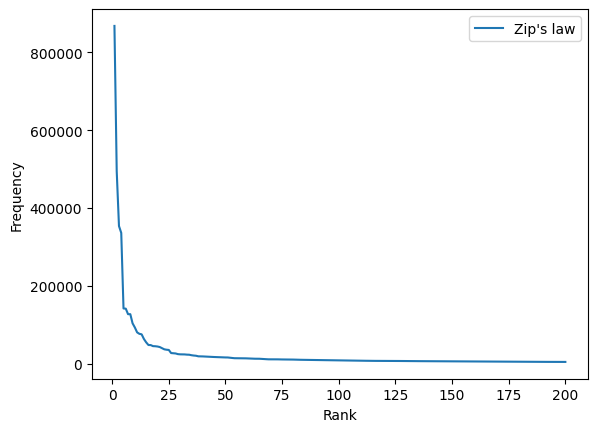

In [ ]:
cdh_n.print_abbreviated_zips_law(0, 200)

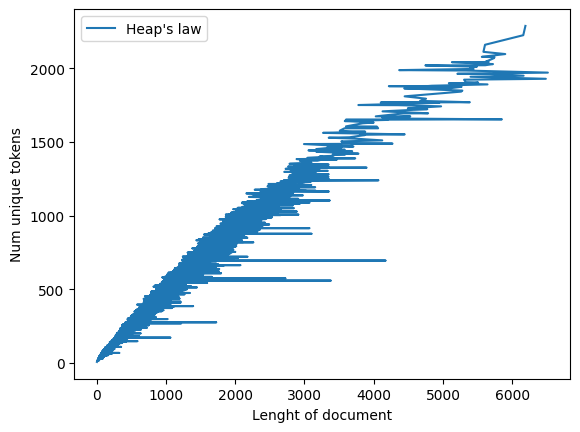

In [ ]:
cdh_n.print_heaps_law()

# Подсчёт статистик для подготовленных данных

In [4]:
columns = ["title", "summary", "content"]

## Без tfidf стоп-слов

In [5]:
d = pd.read_excel("./prepeared_news_without_tfidf.xlsx")
cdh_d = Calc_docs_characteristics(docs=d, columns=columns)

In [6]:
cdh_d.get_statistics()

,characteristic,value
0,num docs,11860
1,num tokens,5233704
2,num unique tokens,18707
3,min num tokens in doc,79
4,mode num tokens in doc,130
5,median num tokens in doc,389
6,average num tokens in doc,441
7,max num tokens in doc,2556
8,min num unique tokens in doc,27
9,mode num unique tokens in doc,187


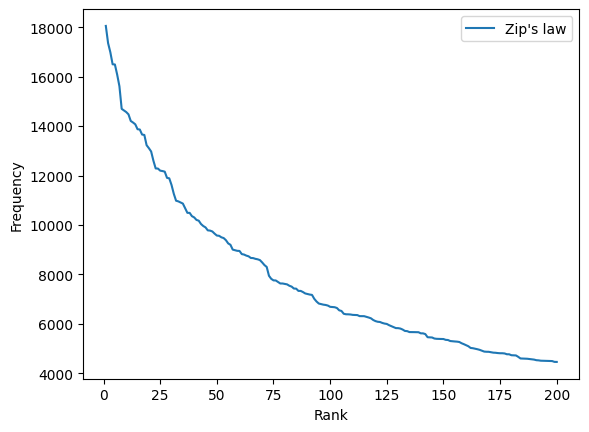

In [7]:
cdh_d.print_abbreviated_zips_law(0, 200)

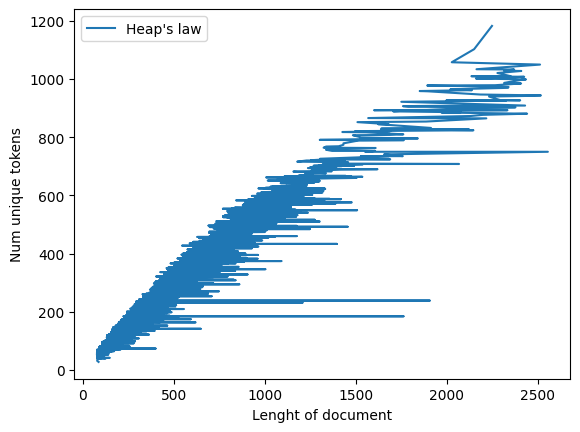

In [8]:
cdh_d.print_heaps_law()

## С tfidf стоп-словами 1 процент

In [9]:
d1 = pd.read_excel("./prepeared_news_with_tfidf_1.xlsx")
cdh_d1 = Calc_docs_characteristics(docs=d1, columns=columns)

In [10]:
cdh_d1.get_statistics()

,characteristic,value
0,num docs,11860
1,num tokens,5181364
2,num unique tokens,18707
3,min num tokens in doc,79
4,mode num tokens in doc,130
5,median num tokens in doc,388
6,average num tokens in doc,436
7,max num tokens in doc,2407
8,min num unique tokens in doc,27
9,mode num unique tokens in doc,187


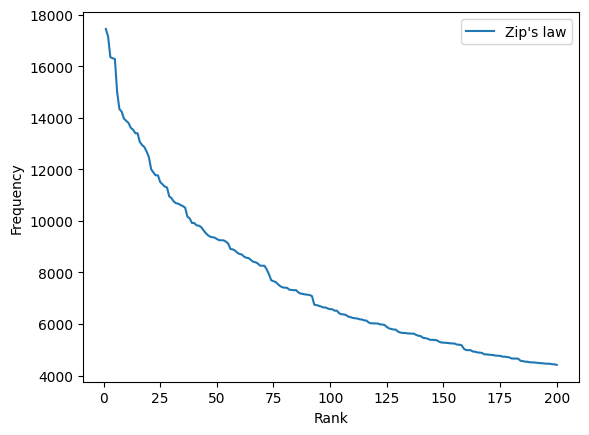

In [11]:
cdh_d1.print_abbreviated_zips_law(0, 200)

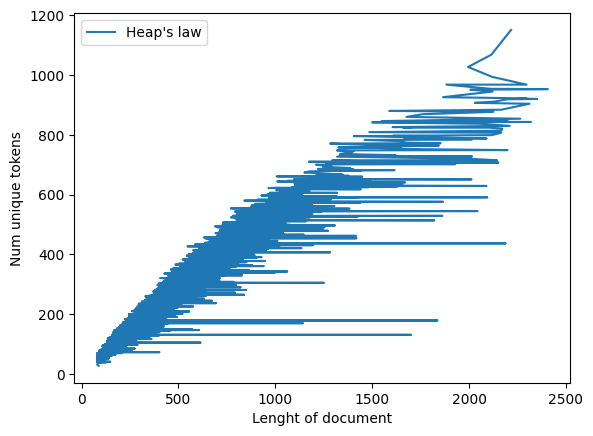

In [12]:
cdh_d1.print_heaps_law()

## С tfidf стоп-словами 2 процента

In [13]:
d2 = pd.read_excel("./prepeared_news_with_tfidf_2.xlsx")
cdh_d2 = Calc_docs_characteristics(docs=d2, columns=columns)

In [14]:
cdh_d2.get_statistics()

,characteristic,value
0,num docs,11860
1,num tokens,5129026
2,num unique tokens,18707
3,min num tokens in doc,79
4,mode num tokens in doc,130
5,median num tokens in doc,385
6,average num tokens in doc,432
7,max num tokens in doc,2318
8,min num unique tokens in doc,27
9,mode num unique tokens in doc,141


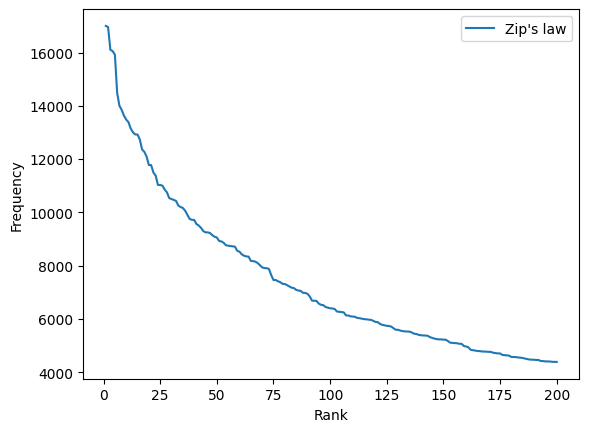

In [15]:
cdh_d2.print_abbreviated_zips_law(0, 200)

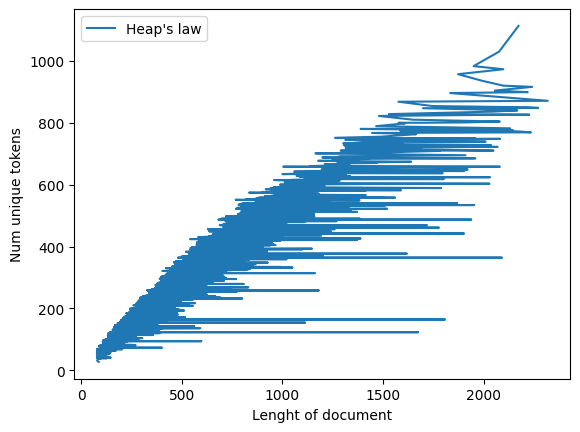

In [16]:
cdh_d2.print_heaps_law()

## С tfidf стоп-словами 3 процента

In [17]:
d3 = pd.read_excel("./prepeared_news_with_tfidf_3.xlsx")
cdh_d3 = Calc_docs_characteristics(docs=d3, columns=columns)

In [18]:
cdh_d3.get_statistics()

,characteristic,value
0,num docs,11860
1,num tokens,5076687
2,num unique tokens,18707
3,min num tokens in doc,79
4,mode num tokens in doc,461
5,median num tokens in doc,382
6,average num tokens in doc,428
7,max num tokens in doc,2243
8,min num unique tokens in doc,27
9,mode num unique tokens in doc,187


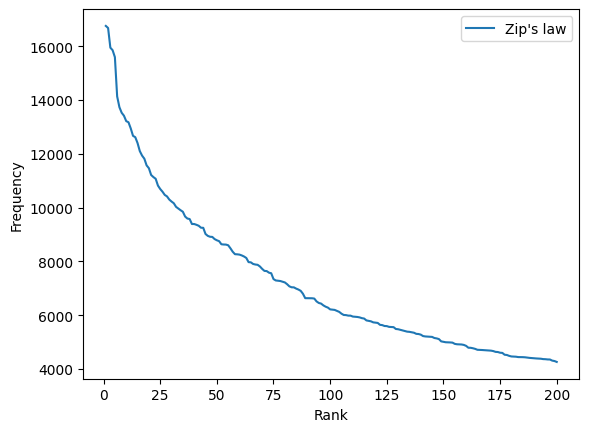

In [19]:
cdh_d3.print_abbreviated_zips_law(0, 200)

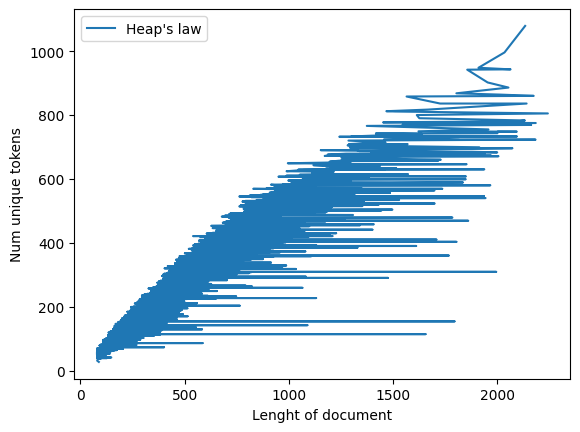

In [20]:
cdh_d3.print_heaps_law()

## С tfidf стоп-словами 4 процента

In [21]:
d4 = pd.read_excel("./prepeared_news_with_tfidf_4.xlsx")
cdh_d4 = Calc_docs_characteristics(docs=d4, columns=columns)

In [22]:
cdh_d4.get_statistics()

,characteristic,value
0,num docs,11860
1,num tokens,5024348
2,num unique tokens,18707
3,min num tokens in doc,79
4,mode num tokens in doc,277
5,median num tokens in doc,379
6,average num tokens in doc,423
7,max num tokens in doc,2185
8,min num unique tokens in doc,27
9,mode num unique tokens in doc,208


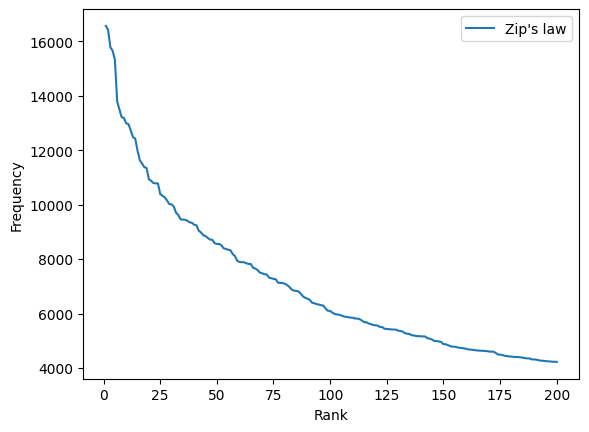

In [23]:
cdh_d4.print_abbreviated_zips_law(0, 200)

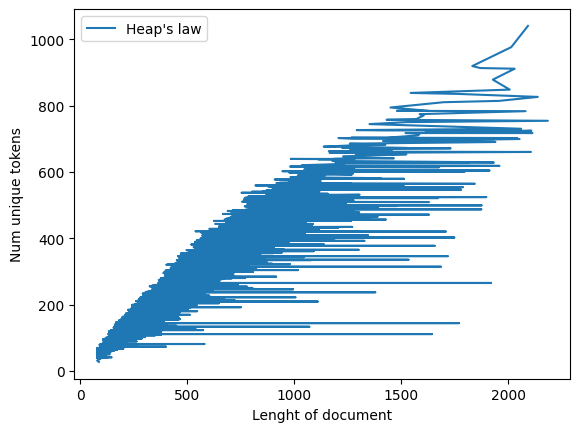

In [24]:
cdh_d4.print_heaps_law()

## С tfidf стоп-словами 5 процентов

In [25]:
d5 = pd.read_excel("./prepeared_news_with_tfidf_5.xlsx")
cdh_d5 = Calc_docs_characteristics(docs=d5, columns=columns)

In [26]:
cdh_d5.get_statistics()

,characteristic,value
0,num docs,11860
1,num tokens,4972009
2,num unique tokens,18707
3,min num tokens in doc,79
4,mode num tokens in doc,359
5,median num tokens in doc,377
6,average num tokens in doc,419
7,max num tokens in doc,2107
8,min num unique tokens in doc,27
9,mode num unique tokens in doc,184


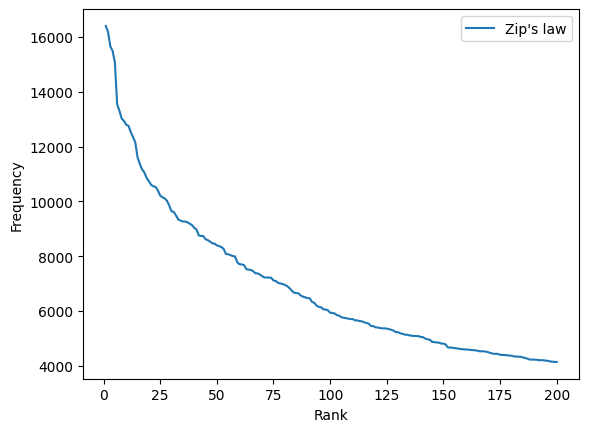

In [27]:
cdh_d5.print_abbreviated_zips_law(0, 200)

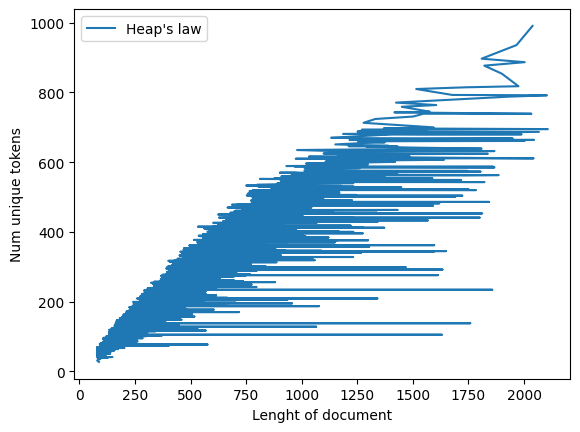

In [28]:
cdh_d5.print_heaps_law()

## С tfidf стоп-словами 6 процентов

In [29]:
d6 = pd.read_excel("./prepeared_news_with_tfidf_6.xlsx")
cdh_d6 = Calc_docs_characteristics(docs=d6, columns=columns)

In [30]:
cdh_d6.get_statistics()

,characteristic,value
0,num docs,11860
1,num tokens,4919670
2,num unique tokens,18707
3,min num tokens in doc,79
4,mode num tokens in doc,167
5,median num tokens in doc,373
6,average num tokens in doc,414
7,max num tokens in doc,2053
8,min num unique tokens in doc,27
9,mode num unique tokens in doc,216


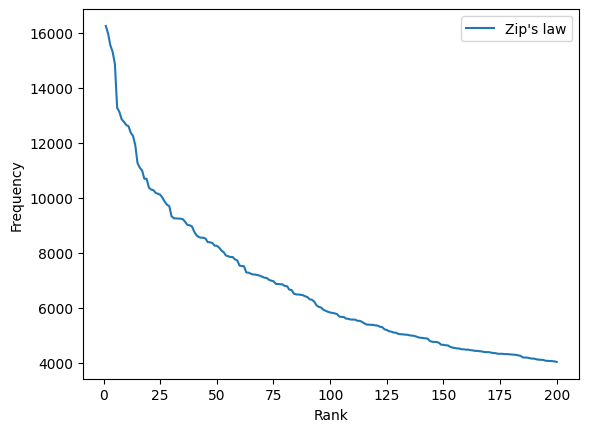

In [31]:
cdh_d6.print_abbreviated_zips_law(0, 200)

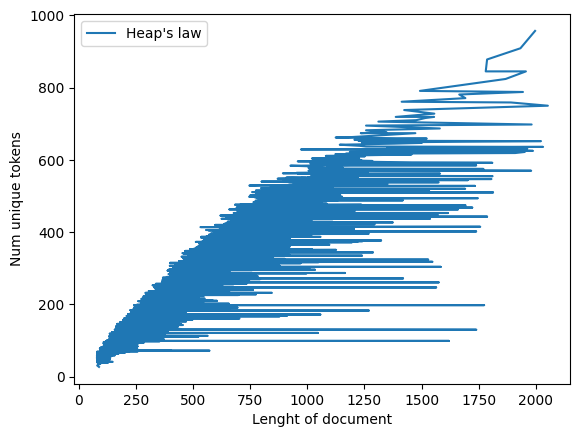

In [32]:
cdh_d6.print_heaps_law()

## С tfidf стоп-словами 7 процентов

In [33]:
d7 = pd.read_excel("./prepeared_news_with_tfidf_7.xlsx")
cdh_d7 = Calc_docs_characteristics(docs=d7, columns=columns)

In [34]:
cdh_d7.get_statistics()

,characteristic,value
0,num docs,11860
1,num tokens,4867331
2,num unique tokens,18707
3,min num tokens in doc,79
4,mode num tokens in doc,355
5,median num tokens in doc,371
6,average num tokens in doc,410
7,max num tokens in doc,2001
8,min num unique tokens in doc,27
9,mode num unique tokens in doc,183


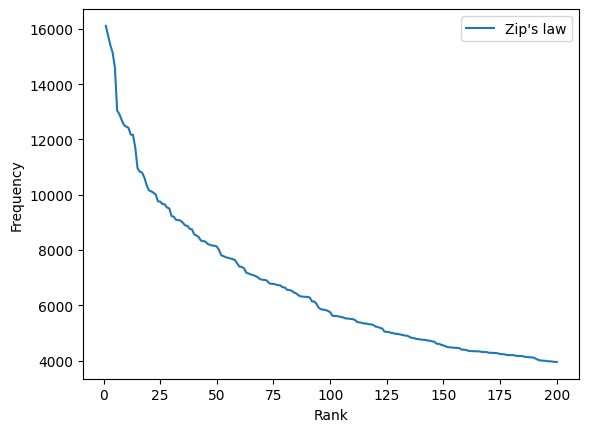

In [35]:
cdh_d7.print_abbreviated_zips_law(0, 200)

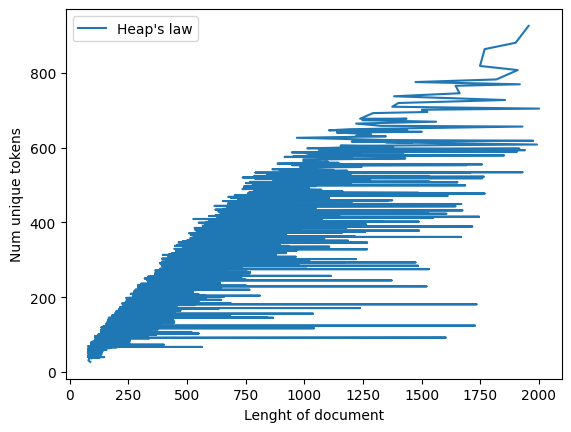

In [36]:
cdh_d7.print_heaps_law()

## С tfidf стоп-словами 8 процентов

In [37]:
d8 = pd.read_excel("./prepeared_news_with_tfidf_8.xlsx")
cdh_d8 = Calc_docs_characteristics(docs=d8, columns=columns)

In [38]:
cdh_d8.get_statistics()

,characteristic,value
0,num docs,11860
1,num tokens,4814992
2,num unique tokens,18707
3,min num tokens in doc,79
4,mode num tokens in doc,372
5,median num tokens in doc,368
6,average num tokens in doc,405
7,max num tokens in doc,1955
8,min num unique tokens in doc,27
9,mode num unique tokens in doc,208


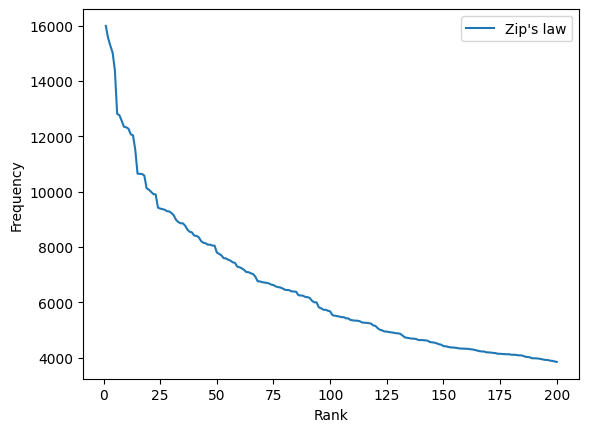

In [39]:
cdh_d8.print_abbreviated_zips_law(0, 200)

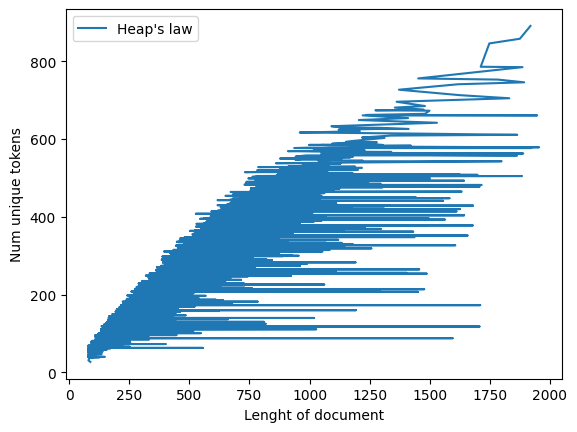

In [40]:
cdh_d8.print_heaps_law()

## С tfidf стоп-словами 9 процентов

In [41]:
d9 = pd.read_excel("./prepeared_news_with_tfidf_9.xlsx")
cdh_d9 = Calc_docs_characteristics(docs=d9, columns=columns)

In [42]:
cdh_d9.get_statistics()

,characteristic,value
0,num docs,11860
1,num tokens,4762654
2,num unique tokens,18707
3,min num tokens in doc,79
4,mode num tokens in doc,282
5,median num tokens in doc,364
6,average num tokens in doc,401
7,max num tokens in doc,1912
8,min num unique tokens in doc,27
9,mode num unique tokens in doc,224


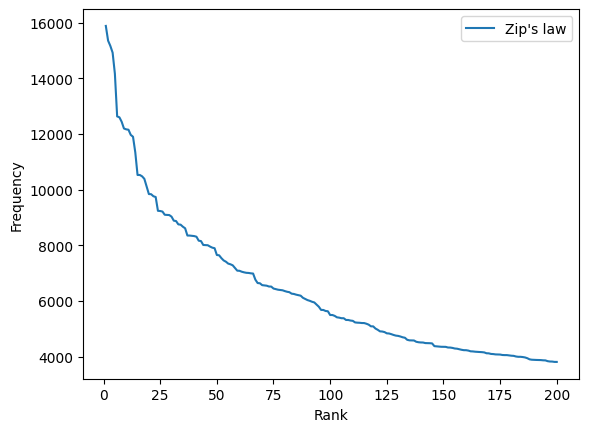

In [43]:
cdh_d9.print_abbreviated_zips_law(0, 200)

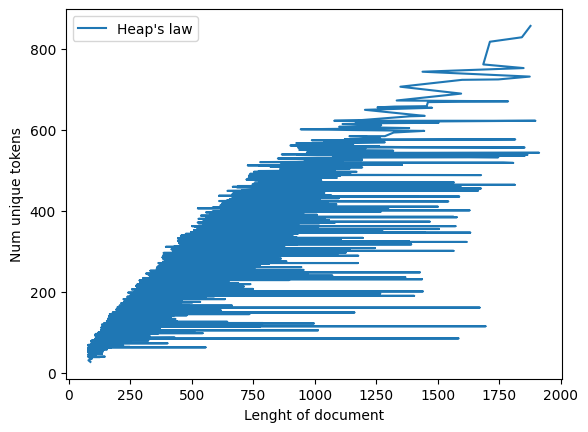

In [44]:
cdh_d9.print_heaps_law()

## С tfidf стоп-словами 10 процентов

In [45]:
d10 = pd.read_excel("./prepeared_news_with_tfidf_10.xlsx")
cdh_d10 = Calc_docs_characteristics(docs=d10, columns=columns)

In [46]:
cdh_d10.get_statistics()

,characteristic,value
0,num docs,11860
1,num tokens,4710315
2,num unique tokens,18707
3,min num tokens in doc,79
4,mode num tokens in doc,186
5,median num tokens in doc,361
6,average num tokens in doc,397
7,max num tokens in doc,1877
8,min num unique tokens in doc,27
9,mode num unique tokens in doc,138


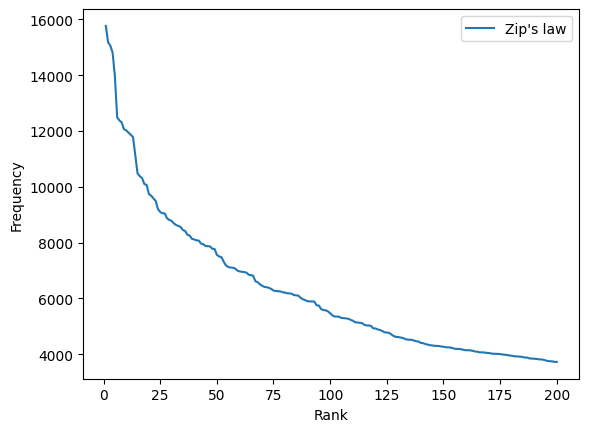

In [47]:
cdh_d10.print_abbreviated_zips_law(0, 200)

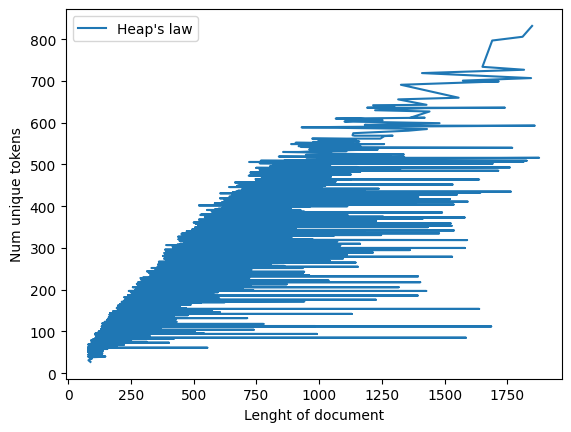

In [48]:
cdh_d10.print_heaps_law()